In [1]:

import matplotlib.pyplot as plt
import nibabel as nib
import pandas as pd
import numpy as np
import scipy.io 
import mne
import os
import sys
sys.path.insert(0, 'E:/workspace/my_py_toolbox/')
from hm_tools import *

in_path = r"E:/workspace/sEEG_slow_fast_attack/roi_data/striatum/" # 分析哪个roi就输入哪个文件夹的数据

behavior_path = r'E:/workspace/sEEG_slow_fast_attack/switch_event/'

subjects = [104, 108, 116, 117, 119, 120] # vmpfc 
# subjects = [104, 108, 109, 112, 113, 116, 117, 119, 120, 124]  # hippo 
# subjects = [109, 116, 119, 120, 122] # striatum  


def gaussian_filter(data, time_span=50, fs=1000, axis=-1):

    # time_span: the length of the window (ms)
    from scipy import signal, ndimage

    winsize = time_span * fs / 1000

    # create a window(kernel) with value follow a gaussian distrubution
    window = signal.gaussian(winsize,std = int((winsize)/5) ) # Note! In matlab function 'gausswin',the parameter is α(defaut = 2.5), here is std, std = winsize/2α

    # Make the sum of the window = 1
    gusWin = window/sum(window)

    # convolve the last dimension
    data_filtered = ndimage.convolve1d(input=data, weights=gusWin, axis=axis, mode='nearest', origin=0)

    return data_filtered

In [6]:
from mne.time_frequency import tfr_morlet
# 新event编号
# 未发生攻击类别改变：
# 快攻击逃脱：11；  快攻击捕捉：12；  慢攻击逃脱：13；  慢攻击捕捉：14；  慢攻击太快: 20； 
# 发生攻击类别改变：
# 快攻击逃脱：21；  快攻击捕捉：22；  慢攻击逃脱：23；  慢攻击捕捉：24；  慢攻击太快: 30； 
freqs=np.arange(70, 120, 5)
n_cycles=10
time_span = 100
ch_names = []
all_smooth_hgb_fast_data=[]
for i in range(len(subjects)):

    ROI_epochs = mne.read_epochs_eeglab(in_path + str(subjects[i]) + '.set')
    if subjects[i]==108:
        ROI_epochs.events[61, 2] = 3
    if subjects[i]==119:
        ROI_epochs.events[49, 2] = 1
    if subjects[i]==109:
        ROI_epochs.events[4, 2] = 1
    

    each_trial_information = pd.read_table(behavior_path + str(subjects[i]) + "each_switch_trial_information.txt", delimiter=" ")

    # 仅仅正确的慢攻击
    # no_switch_event = np.squeeze(np.where(each_trial_information['trial_condition']==13))
    # switch_event = np.squeeze(np.where(each_trial_information['trial_condition']==23))

    # 仅仅正确的快攻击
    no_switch_event = np.squeeze(np.where(each_trial_information['trial_condition']==11))
    switch_event = np.squeeze(np.where(each_trial_information['trial_condition']==21))
 
    tfr_ROI_epoch_fast = tfr_morlet(ROI_epochs[no_switch_event], freqs, n_cycles=n_cycles, return_itc=False, average = True, use_fft=True)
    tfr_ROI_epoch_slow = tfr_morlet(ROI_epochs[switch_event], freqs, n_cycles=n_cycles, return_itc=False, average = True, use_fft=True)

    tfr_ROI_epoch_fast.apply_baseline(mode='logratio', baseline=(-0.1, 0)) # 'mean' | 'ratio' | 'logratio' | 'percent' | 'zscore' | 'zlogratio'
    tfr_ROI_epoch_slow.apply_baseline(mode='logratio', baseline=(-0.1, 0)) # 'mean' | 'ratio' | 'logratio' | 'percent' | 'zscore' | 'zlogratio'

    smooth_hgb_fast_data = gaussian_filter(data=np.mean(tfr_ROI_epoch_fast.data,axis=1), time_span=time_span, fs=ROI_epochs.info['sfreq'])
    smooth_hgb_slow_data = gaussian_filter(data=np.mean(tfr_ROI_epoch_slow.data,axis=1), time_span=time_span, fs=ROI_epochs.info['sfreq'])

    
    if i == 0:
        all_smooth_hgb_fast_data = smooth_hgb_fast_data
        all_smooth_hgb_slow_data = smooth_hgb_slow_data
        ch_names = np.array(ROI_epochs.ch_names)
    else:
        all_smooth_hgb_fast_data = np.vstack((all_smooth_hgb_fast_data, smooth_hgb_fast_data))
        all_smooth_hgb_slow_data = np.vstack((all_smooth_hgb_slow_data, smooth_hgb_slow_data))
        ch_names = np.hstack((ch_names, np.array(ROI_epochs.ch_names)))

Extracting parameters from E:/workspace/sEEG_slow_fast_attack/roi_data/striatum/109.set...
Not setting metadata
Not setting metadata
80 matching events found
No baseline correction applied
0 projection items activated
Ready.


Applying baseline correction (mode: logratio)
Applying baseline correction (mode: logratio)
Extracting parameters from E:/workspace/sEEG_slow_fast_attack/roi_data/striatum/116.set...


<ipython-input-6-64bf43ea619d>:14: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  ROI_epochs = mne.read_epochs_eeglab(in_path + str(subjects[i]) + '.set')
<ipython-input-6-64bf43ea619d>:14: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  ROI_epochs = mne.read_epochs_eeglab(in_path + str(subjects[i]) + '.set')


Not setting metadata
Not setting metadata
80 matching events found
No baseline correction applied
0 projection items activated
Ready.
Applying baseline correction (mode: logratio)
Applying baseline correction (mode: logratio)
Extracting parameters from E:/workspace/sEEG_slow_fast_attack/roi_data/striatum/119.set...
Not setting metadata
Not setting metadata
80 matching events found
No baseline correction applied
0 projection items activated
Ready.
Applying baseline correction (mode: logratio)
Applying baseline correction (mode: logratio)
Extracting parameters from E:/workspace/sEEG_slow_fast_attack/roi_data/striatum/120.set...
Not setting metadata
Not setting metadata
80 matching events found
No baseline correction applied
0 projection items activated
Ready.


<ipython-input-6-64bf43ea619d>:14: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  ROI_epochs = mne.read_epochs_eeglab(in_path + str(subjects[i]) + '.set')
<ipython-input-6-64bf43ea619d>:14: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  ROI_epochs = mne.read_epochs_eeglab(in_path + str(subjects[i]) + '.set')


Applying baseline correction (mode: logratio)
Applying baseline correction (mode: logratio)
Extracting parameters from E:/workspace/sEEG_slow_fast_attack/roi_data/striatum/122.set...
Not setting metadata
Not setting metadata
80 matching events found
No baseline correction applied
0 projection items activated
Ready.


<ipython-input-6-64bf43ea619d>:14: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  ROI_epochs = mne.read_epochs_eeglab(in_path + str(subjects[i]) + '.set')


Applying baseline correction (mode: logratio)
Applying baseline correction (mode: logratio)


In [7]:
# create a new epochs info
info = mne.create_info(ch_names = list(ch_names), ch_types = 'eeg', sfreq = 1000)

# create a new ROI based epochs
all_smooth_hgb_fast = mne.EvokedArray(data = all_smooth_hgb_fast_data, info = info, tmin=-0.5)
all_smooth_hgb_slow = mne.EvokedArray(data = all_smooth_hgb_slow_data, info = info, tmin=-0.5)
all_smooth_hgb_fast.apply_baseline(baseline=(-0.1, 0))
all_smooth_hgb_slow.apply_baseline(baseline=(-0.1, 0))

times = all_smooth_hgb_slow.times

all_smooth_hgb_fast_crop = all_smooth_hgb_fast
all_smooth_hgb_slow_crop = all_smooth_hgb_slow

all_smooth_hgb_fast_crop = all_smooth_hgb_fast_crop.crop(-0.1, 1.0)
all_smooth_hgb_slow_crop = all_smooth_hgb_slow_crop.crop(-0.1, 1.0)

n_permutations = 10000

# 两种情况下相对于0的显著性
T_obs_fast, clusters_fast, cluster_p_values_fast, H0_fast  = mne.stats.permutation_cluster_1samp_test(all_smooth_hgb_fast_crop.data, 
                                                    out_type='mask',n_permutations=n_permutations, t_power=1, n_jobs=4, tail=0, verbose=None)

T_obs_slow, clusters_slow, cluster_p_values_slow, H0_slow  = mne.stats.permutation_cluster_1samp_test(all_smooth_hgb_slow_crop.data, 
                                                    out_type='mask',n_permutations=n_permutations, t_power=1, n_jobs=4, tail=0, verbose=None)


# 两者之间的显著性
T_obs, clusters, cluster_p_values, H0 = mne.stats.permutation_cluster_test([all_smooth_hgb_slow_crop.data, all_smooth_hgb_fast_crop.data],
                                                                out_type='mask', n_permutations=n_permutations, n_jobs=4,tail=0
                                                                ,verbose=None, t_power=1)


Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Using a threshold of 2.100922
stat_fun(H1): min=-2.359863 max=2.920413
Running initial clustering
Found 5 clusters
Permuting 9999 times...


<ipython-input-7-a5f1f30fda0b>:2: RuntimeWarning: Channel names are not unique, found duplicates for: {'CI1'}. Applying running numbers for duplicates.
  info = mne.create_info(ch_names = list(ch_names), ch_types = 'eeg', sfreq = 1000)
100%|██████████|  : 9999/9999 [00:03<00:00, 3184.01it/s]

Computing cluster p-values
Done.
Using a threshold of 2.100922
stat_fun(H1): min=-1.463649 max=3.491729
Running initial clustering
Found 6 clusters


Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:03<00:00, 3030.85it/s]


Computing cluster p-values
Done.
Using a threshold of 4.113165
stat_fun(H1): min=0.000320 max=6.800406
Running initial clustering
Found 3 clusters


<ipython-input-7-a5f1f30fda0b>:32: RuntimeWarning: Ignoring argument "tail", performing 1-tailed F-test
  T_obs, clusters, cluster_p_values, H0 = mne.stats.permutation_cluster_test([all_smooth_hgb_slow_crop.data, all_smooth_hgb_fast_crop.data],


Permuting 9999 times...


100%|██████████|  : 9999/9999 [00:03<00:00, 2792.24it/s]

Computing cluster p-values
Done.


<ipython-input-9-d679f0e3b424>:118: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "overwrite" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(r'D:\Desktop\项目\seeg\画图\hga_all\switching_fast_striatum.jpg',dpi=300, overwrite=True)


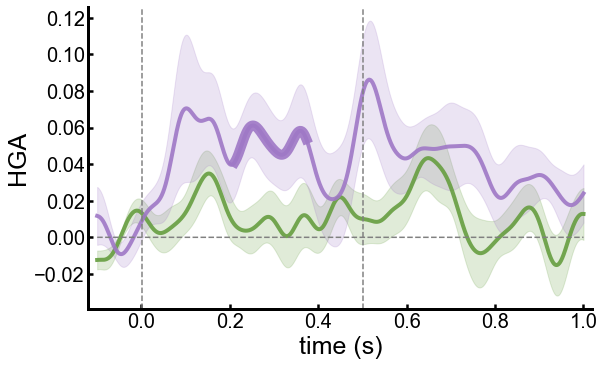

: 

In [9]:

line_color = ['#669E40', '#9F78C6']    # 绿色 和 紫色
# line_color = ['#E36A65','#FF943C']    # 红色橙色 正确快攻击，错误快攻击  DE6B48  FFADC6
# line_color = ['#5CBBBF','#4482CD']    #  正确慢攻击，过快慢攻击  DE6B48  FFADC6
# line_color = ['#FF943C','#4482CD']    #  错误快攻击，过快慢攻击  DE6B48  FFADC6

figsize=(10,6) 
title_size=20
legend_size=15

ticksize=10
subplots_adjust=[0.15, 0.15, 0.85, 0.85]


import matplotlib.pyplot as plt
import numpy as np
import os

# if not os.path.exists(result_path):
# os.mkdir(result_path)    
# # plot for each ROI
# for ROI_num in range(len(permutation_cluster_result['ROI_name'])):

event_0_line_color = line_color[0]
event_1_line_color = line_color[1]

# the number of time axis
times = all_smooth_hgb_slow.times

plt.close('all')
plt.rcParams['figure.figsize'] = figsize # 设置figure_size尺寸
# plt.title('ROI: '+ roi_name, fontdict={'fontsize':title_size})

epoch_mean={}
epoch_mean[0] = np.squeeze(np.average(all_smooth_hgb_fast.data, axis=0))
epoch_mean[1] = np.squeeze(np.average(all_smooth_hgb_slow.data, axis=0))

plt.plot(times, epoch_mean[0], color=line_color[0], alpha=0.9, linewidth=4) # , linestyle='--')
plt.plot(times, epoch_mean[1], color=line_color[1], alpha=0.9, linewidth=4) # , linestyle='--')

# Draw the dividing line at 0s 
plt.axvline(times[101], c="gray", ls = "dashed")
plt.axvline(times[601], c="gray", ls = "dashed")
plt.plot(times, np.zeros(len(epoch_mean[0])), color="gray", linestyle="--")

# Drawing error (std)
std_event0 = np.squeeze(np.std(all_smooth_hgb_fast.data, axis=0))
std_event1 = np.squeeze(np.std(all_smooth_hgb_slow.data, axis=0))

se_event0 = std_event0/np.sqrt(all_smooth_hgb_fast.data.shape[0])
se_event1 = std_event1/np.sqrt(all_smooth_hgb_fast.data.shape[0])

plt.fill_between(times, epoch_mean[0] - se_event0, epoch_mean[0] + se_event0, color=line_color[0], alpha=0.2)
plt.fill_between(times, epoch_mean[1] - se_event1, epoch_mean[1] + se_event1, color=line_color[1], alpha=0.2)

# condition 0 to baseline
for i_c, c in enumerate(clusters_fast):
    c = c[0]
    if cluster_p_values_fast[i_c] <= 0.05:
        # plt.axvspan(times[c.start], times[c.stop - 1], color='r', alpha=0.3)
        plt.plot(times[c.start : c.stop - 1], epoch_mean[0][c.start : c.stop-1], color=event_0_line_color, alpha=0.9, linewidth=10)
# condition 1 to baseline
for i_c, c in enumerate(clusters_slow):
    c = c[0]
    if cluster_p_values_slow[i_c] <= 0.05:
        # plt.axvspan(times[c.start], times[c.stop - 1], color='r', alpha=0.3)
        plt.plot(times[c.start : c.stop - 1], epoch_mean[1][c.start : c.stop-1], color=event_1_line_color, alpha=0.9, linewidth=10)

# condition 0 and condition 1
for i_c, c in enumerate(clusters):
    c = c[0]
    if cluster_p_values[i_c] <= 0.05:
        
        plt.plot(times[c.start : c.stop - 1], -0.05 * np.ones(len(epoch_mean[0]))[c.start : c.stop-1], color='#5EACFF', alpha=0.9, linewidth=10)

#hf = plt.plot(times, T_obs, 'g')
#plt.legend((h, ), ('cluster p-value < 0.05', ))
plt.subplots_adjust(left=subplots_adjust[0], bottom=subplots_adjust[1], right=subplots_adjust[2], top=subplots_adjust[3], hspace=0.1,wspace=0.1)

plt.xlim([times[0]-0.02, times[-1]+0.02])

plt.yticks(size=ticksize)
plt.xticks(size=ticksize)

spines_width = 3
ax=plt.gca()
ax.spines['top'].set_linewidth(0)
ax.spines['right'].set_linewidth(0)
ax.spines['left'].set_linewidth(spines_width)
ax.spines['bottom'].set_linewidth(spines_width)
# sns.despine()

# 坐标轴刻度粗细,朝内
plt.rcParams['xtick.major.size'] = 5
plt.rcParams['ytick.major.size'] = 5
plt.rcParams['xtick.major.width'] = 2.5
plt.rcParams['ytick.major.width'] = 2.5
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
# plt.set_ylabel("Escape Accuracy", size=ticksize, fontproperties='Arial')

labelsize=25
plt.xlabel("time (s)", fontsize=labelsize, fontproperties='Arial')
plt.ylabel("HGA", size=labelsize, fontproperties='Arial')

# 坐标的粗细
ticksize = 20
plt.yticks(size=ticksize, fontproperties='Arial')
plt.xticks(size=ticksize, fontproperties='Arial')
# plt.savefig(r'D:\Desktop\项目\seeg\画图\hga_all\switching_fast_striatum.jpg',dpi=300, overwrite=True)

# plt.savefig(result_path + '/' + permutation_cluster_result['ROI_name'][ROI_num] + ".png", overwrite=True)

In [133]:
plt.plot(mask)

NameError: name 'mask' is not defined

In [10]:
clusters

[(slice(200, 370, None),), (slice(879, 908, None),)]

In [16]:
cluster_p_values_fast

array([0.5887, 0.3536, 0.3919, 0.0233, 0.0144])

In [17]:
cluster_p_values_slow

array([0.0489, 0.5255, 0.3047])

In [18]:
cluster_p_values

array([0.6136, 0.3683, 0.359 , 0.3402, 0.3617, 0.0648])

In [45]:
all_smooth_hgb_slow_crop

<Evoked | '' (average, N=1), -0.1 – 1 sec, baseline -0.1 – 0 sec, 2 ch, ~24 kB>

In [72]:
cluster_p_values

array([0.5532, 0.403 , 0.3728, 0.485 , 0.0331, 0.2817])

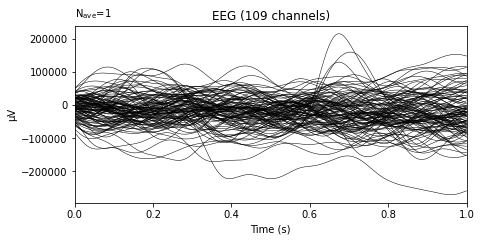

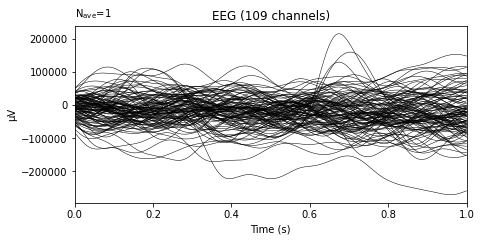

In [171]:
all_smooth_hgb_fast.plot()

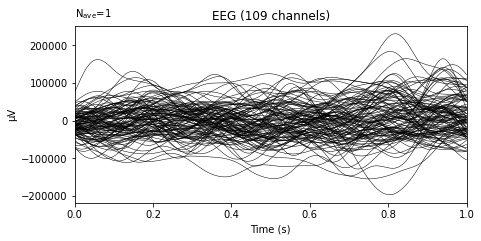

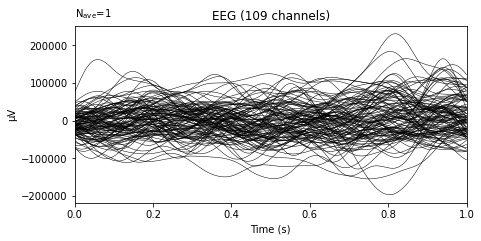

In [172]:
all_smooth_hgb_slow.plot()

In [131]:
cluster_p_values

array([0.51209])

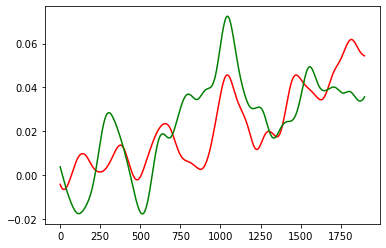

In [54]:
tfr_ROI_epoch = tfr_morlet(ROI_epochs, freqs, n_cycles=n_cycles, return_itc=False, average = False, use_fft=True)


Not setting metadata


In [56]:
freqs

array([ 60,  62,  64,  66,  68,  70,  72,  74,  76,  78,  80,  82,  84,
        86,  88,  90,  92,  94,  96,  98, 100, 102, 104, 106, 108, 110,
       112, 114, 116, 118])

In [55]:
tfr_ROI_epoch['1/5/6']

<EpochsTFR | time : [-0.500000, 3.999000], freq : [60.000000, 118.000000], epochs : 25, channels : 6, ~154.5 MB>

In [23]:
tfr_ROI_epoch.data.shape

(3, 11, 2101)

Extracting parameters from E:/workspace/sEEG_slow_fast_attack/roi_data/amy/108.set...
Not setting metadata
Not setting metadata
80 matching events found
No baseline correction applied
0 projection items activated
Ready.


<ipython-input-50-110ec8dfc67d>:1: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  ROI_epochs = mne.read_epochs_eeglab(in_path + str(subjects[1]) + '.set')


No baseline correction applied


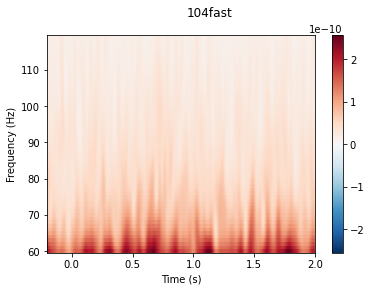

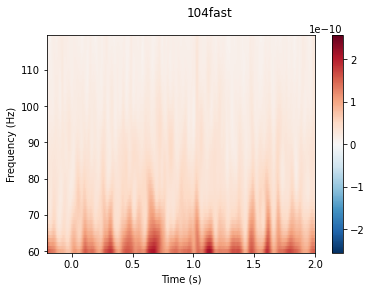

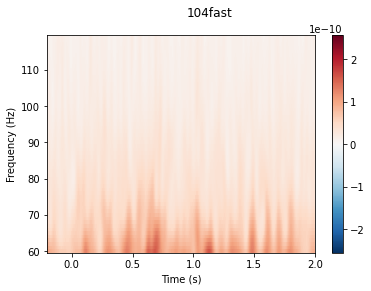

<bound method save of <AverageTFR | time : [-0.200000, 2.000000], freq : [60.000000, 119.000000], nave : 30, channels : 3, ~3.0 MB>>

In [50]:

ROI_epochs = mne.read_epochs_eeglab(in_path + str(subjects[1]) + '.set')

from mne.time_frequency import tfr_morlet


freqs=np.arange(60, 120, 1)
n_cycles=10

tfr_ROI_epoch = tfr_morlet(ROI_epochs['1/5/6'], freqs, n_cycles=n_cycles, return_itc=False, average = True, use_fft=True)

tfr_ROI_epoch.crop(-0.2, 2.0)
tfr_ROI_epoch.plot(baseline=(-0.1, 0), mode="logratio", title=str(subjects[0]) + 'fast') #, vmin=-0.5, vmax=0.5)
tfr_ROI_epoch.save
# 'mean' | 'ratio' | 'logratio' | 'percent' | 'zscore' | 'zlogratio'

Applying baseline correction (mode: logratio)


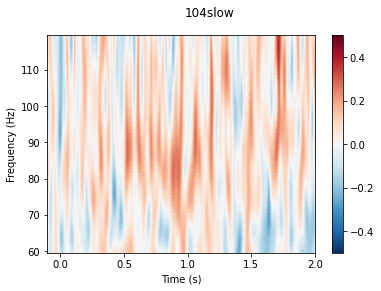

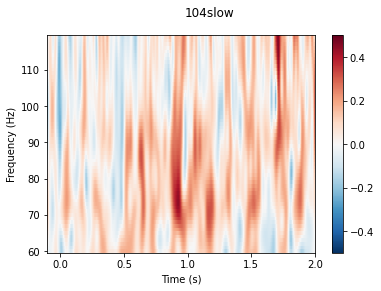

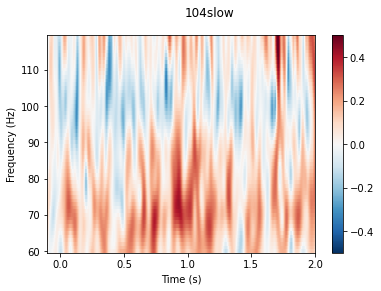

[<Figure size 432x288 with 2 Axes>,
 <Figure size 432x288 with 2 Axes>,
 <Figure size 432x288 with 2 Axes>]

In [49]:
tfr_ROI_epoch = tfr_morlet(ROI_epochs['3/5/6'], freqs, n_cycles=n_cycles, return_itc=False, average = True, use_fft=True)
tfr_ROI_epoch.crop(-0.1, 2.0)
# '3/5/6'
tfr_ROI_epoch.plot(baseline=(-0.1, 0), mode="logratio", title=str(subjects[0] )+ 'slow', vmin=-0.5, vmax=0.5)

In [ ]:
# 快攻击成功是 '1/5/6'
# 快攻击失败是 '2/5/7/8'
# 慢攻击成功是 '3/5/6'

In [ ]:
def calculate_tfr(epochs, freqs=np.arange(70, 180, 5), n_cycles=5):

    from mne.time_frequency import tfr_morlet
    #freqs = np.arange(70, 180, 5)
    #n_cycles = 5

    tfr_ROI_epoch = tfr_morlet(epochs, freqs, n_cycles=n_cycles, return_itc=False, average = False)
    
    return tfr_ROI_epoch

def gaussian_filter(data, time_span=50, fs=1000, axis=-1):

    # time_span: the length of the window (ms)
    from scipy import signal, ndimage

    winsize = time_span * fs / 1000

    # create a window(kernel) with value follow a gaussian distrubution
    window = signal.gaussian(winsize,std = int((winsize)/5) ) # Note! In matlab function 'gausswin',the parameter is α(defaut = 2.5), here is std, std = winsize/2α

    # Make the sum of the window = 1
    gusWin = window/sum(window)

    # convolve the last dimension
    data_filtered = ndimage.convolve1d(input=data, weights=gusWin, axis=axis, mode='nearest', origin=0)

    return data_filtered

In [16]:
epochs_standard

Number of events,160
Events,1/5/6: 7610/5/6: 122/5/7/8: 43/5/6: 664/5/7/8: 2
Time range,-0.500 – 3.999 sec
Baseline,off


In [11]:
ROI_epochs.event_id

# 快攻击成功是 '1/5/6'
# 快攻击失败是 '2/5/7/8'
# 慢攻击成功是 '3/5/6'
# 慢攻击捕捉是 '4/5/7/8'
# 慢攻击过早是 '10/5/6'

{'1/5/6': 1, '10/5/6': 2, '3/5/6': 3, '2/5/7/8': 4, '4/5/7/8': 5}

In [13]:
ROI_epochs['3/5/6']

Number of events,33
Events,3/5/6: 33
Time range,-0.500 – 3.999 sec
Baseline,off


In [7]:
ROI_epochs

Number of events,80
Events,1/5/6: 3810/5/6: 62/5/7/8: 23/5/6: 334/5/7/8: 1
Time range,-0.500 – 3.999 sec
Baseline,off


In [ ]:
ROI_epochs = mne.read_epochs(folder_path +'/'+ 'biomo_aalepo.fif', preload = True)
ROI_epochs.resample(sfreq=1000)
ROI_epochs.apply_baseline(baseline=(-0.2, 0))
good_ROI_names = [i for i in ROI_epochs.info['ch_names'] if i not in ROI_epochs.info['bads']]
#good_ROI_names = ROI_epochs.info['ch_names']

In [ ]:
from mne.time_frequency import tfr_morlet

freqs = np.arange(1, 120, 1)
n_cycles = freqs/2
cycle_max = 7
for iter_c in range(len(n_cycles)):
    if n_cycles[iter_c] > cycle_max:
        n_cycles[iter_c] = cycle_max

tfr_ROI_epoch = tfr_morlet(ROI_epochs, freqs, n_cycles, return_itc=False, average = False, n_jobs=4)
tfr_ROI_epoch.apply_baseline(mode='logratio', baseline=(-0.2, 0)) # 'mean' | 'ratio' | 'logratio' | 'percent' | 'zscore' | 'zlogratio'
tfr_ROI_epoch.crop(-0.2, 2.0)

In [ ]:
tfr_data_resam = mne.filter.resample(tfr_ROI_epoch.data, down=10, npad='auto', n_jobs=4)

In [ ]:
resam_tfr = mne.time_frequency.EpochsTFR(info=tfr_ROI_epoch.info, data=tfr_data_resam, times=np.arange(-0.2, 2.0, 0.01), freqs=tfr_ROI_epoch.freqs, method=tfr_ROI_epoch.method, events=tfr_ROI_epoch.events, event_id=tfr_ROI_epoch.event_id)

In [ ]:
resam_tfr.save(result_path+ '/resam_tfr_logr_aal3',overwrite=True)

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import numpy as np
import os
    
hm_make_dir(result_path + '/erp_plot_logr_aal3/')
for iter_roi in range(len(resam_tfr.ch_names)):
    plt.figure()
    plt.subplots_adjust(0.12, 0.08, 0.96, 0.94, 0.2, 0.43)
    plt.imshow(np.mean(resam_tfr['Reverse'].data[:,iter_roi],axis=0), cmap=plt.cm.RdBu_r,aspect='auto', origin='lower', vmin=-0.5, vmax=0.4, extent=[-0.2, 1.99, 1, 119])
    plt.colorbar()
    plt.xlabel("time (s)")
    plt.ylabel("logratio")
    plt.savefig(result_path + '/erp_plot_logr_aal3/' + '/' + resam_tfr.ch_names[iter_roi] + "_reverse.png")

    plt.figure()
    plt.subplots_adjust(0.12, 0.08, 0.96, 0.94, 0.2, 0.43)
    plt.imshow(np.mean(resam_tfr['Forward'].data[:,iter_roi],axis=0), cmap=plt.cm.RdBu_r,aspect='auto', origin='lower', vmin=-0.5, vmax=0.4, extent=[-0.2, 1.99, 1, 119])
    plt.colorbar()
    plt.xlabel("time (s)")
    plt.ylabel("logratio")

    plt.savefig(result_path + '/erp_plot_logr_aal3/' + '/' + resam_tfr.ch_names[iter_roi] + "_forward.png")

In [ ]:
permutation_cluster_result={}
for iter_roi in range(resam_tfr['Reverse'].data.shape[1]):
    T_obs, clusters, cluster_p_values, H0 = mne.stats.permutation_cluster_test([resam_tfr['Reverse'].data[:,iter_roi], resam_tfr['Forward'].data[:,iter_roi]],
                                                                    out_type='mask', n_permutations=10000, n_jobs=4,tail=0)
    # put them in a dict
    compare_result = {'T_obs':T_obs, 'clusters':clusters, 'cluster_p_values':cluster_p_values, 'H0':H0}
    permutation_cluster_result_per_roi = {'compare_result':compare_result}
    permutation_cluster_result[iter_roi] = permutation_cluster_result_per_roi

In [ ]:
len(tfr_ROI_epoch.ch_names)

In [ ]:
T_obs_plot = np.nan * np.ones_like(T_obs)
for c, p_val in zip(clusters, cluster_p_values):
    if p_val <= 0.05:
        print('yes')
        #T_obs_plot[c] = T_obs[c]

In [ ]:

import matplotlib.pyplot as plt

plt.figure()
plt.subplots_adjust(0.12, 0.08, 0.96, 0.94, 0.2, 0.43)
plt.imshow(raw[56,20], cmap=plt.cm.RdBu_r,aspect='auto', origin='lower', extent=[-0.2, 1.99, 1, 119])
plt.colorbar()
#plt.plot([0,0.5], [20,30])

In [ ]:
plt.plot([0,0.5], [20,30])

In [ ]:
# 如果是high gamma band 的 tfr 就运行这个
tfr_ROI_epoch_data = {}
for event_num in range(len(event)):
    # extract data
    tfr_ROI_epoch_data[event_num] = tfr_ROI_epoch[event[event_num]].data

    #gaussian filter (smooth)
    tfr_ROI_epoch_data[event_num] = gaussian_filter(data=tfr_ROI_epoch_data[event_num], time_span=50, fs=ROI_epochs.info['sfreq'],                                                         axis=-1)

    # average the frequency between HGB
    tfr_ROI_epoch_data[event_num] = np.average(tfr_ROI_epoch_data[event_num], axis=2)

del tfr_ROI_epoch